In [ ]:
# ## TODO - For Prompt
# async def generate_user_story(self, project_name: str, requirement: str, feedback_reason: str, index: int) -> UserStories:
#         prompt = f"""
#         You are an expert in software development and requirements analysis. Based on the project name "{project_name}" and the following requirement:
#         - {requirement}

#         Please generate a user story in Markdown format. The user story should include:
#         - A unique identifier: {index}
#         - A title
#         - A detailed description
#         - The current status (e.g., "To Do")

#         {f"When creating this user story, please incorporate the following feedback about the requirements: {feedback_reason}" if feedback_reason else ""}

#         Format the user story as a bullet point.
#         """
#         system_message = prompt.format(project_name= project_name, requirement= requirement, index= index)
#         llm_with_structured = self.llm.with_structured_output(UserStories)
#         response = llm_with_structured.invoke(system_message)
#         return response

In [18]:
from typing_extensions import TypedDict, Annotated, List, Literal
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.graph import add_messages
from typing import Dict, List, Optional, Union, Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display 
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

In [19]:
## User stories state
class ProjectRequirements(TypedDict):
    title: str
    description: str
    requirements : List[str]

class UserStory(TypedDict):
    story_id : str
    title : str
    description : str 
    acceptance_criteria : List[str]

class UserStoryState(TypedDict):
    project_requirements : ProjectRequirements
    status: Literal["in_progress", "pending_approval", "completed", "feedback"] = "in_progress"
    revised_count : int = 0
    user_stories : List[UserStory]
    user_stories_messages: Annotated[list, add_messages]

In [20]:
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv
load_dotenv()
import os 

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['LANGSMITH_API_KEY'] = os.getenv("LANGSMITH_API_KEY")
os.environ['LANGSMITH_PROJECT'] = os.getenv("LANGSMITH_PROJECT")
os.environ['LANGSMITH_TRACING'] = os.getenv("LANGSMITH_TRACING")

In [21]:
from langchain_groq import ChatGroq 
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [22]:
generate_user_stories_system_prompt = """
**ROLE & OBJECTIVE**

You are an expert Agile Product Owner. Your task is to analyze structured project requirements and generate clear, actionable 3 to 5 user stories ready for development. Retun the OUTPUT in the JSON format only. 

---

**TASK BREAKDOWN:**
1. **Analyze** project requirements, objectives, and user needs.
2. **Extract** core features and define user roles.
3. **Decompose** requirements into independent, testable user stories.
4. **Generate** user stories using:
   - **As a [user], I want [goal], so that [value].**
   - Clear, testable **acceptance criteria**.
5. **Prioritize** based on business impact and feasibility.

---

**DESIRED OUTPUT TEMPLATE IN LIST OF JSON**

```
[
    {
        "story_id"="US-001",
        "title"="Manage Shopping Cart",
        "description"="As a shopper, I want to modify my cart before checkout.",
        "acceptance_criteria"=[
            "User can add/remove items.",
            "User can update item quantity.",
            "Cart updates reflect in real-time.",
            "User can see the total price of the cart."
        ]
    },
    {
        "story_id"="US-002",
        "title"="Apply Discount Code",
        "description"="As a shopper, I want to apply a discount at checkout.",
        "acceptance_criteria"=[
            "User can enter a discount code.",
            "System validates and applies the discount.",
            "Invalid codes show an error message.",
            "User can see the total price after applying the discount."
        ]
    }
]
```

---

**GUIDELINES:**
✅ Align with project requirements.
✅ Use concise, clear language.
✅ Ensure user stories are independent and testable.
✅ Prioritize based on business impact.
✅ The **acceptance criteria must be between 2 to 4 points**—no more, no less.  
🚫 Avoid vagueness, missing criteria, or unnecessary technical details.

"""

In [23]:
revised_user_stories_system_prompt = """

**ROLE & OBJECTIVE**  
You are an expert Agile Product Owner. Your task is to refine user stories based on feedback for clarity, testability, and business alignment.  
Return the output in JSON list format only.  

---

TASK BREAKDOWN:  
1. Analyze `user_story` and `user_feedback`.  
2. Identify gaps and improve clarity.  
3. Ensure user stories follow:  
   - "As a [user], I want [goal], so that [value]."  
   - **2 to 4** clear, testable acceptance criteria.  

---

**DESIRED OUTPUT TEMPLATE IN LIST OF JSON**  
[
    {  
        "story_id": "US-001",  
        "title": "Manage Shopping Cart",  
        "description": "As a shopper, I want to modify my cart before checkout, so that I can finalize my purchase conveniently.",  
        "acceptance_criteria": [  
            "User can add/remove items.",  
            "User can update item quantity.",  
            "Cart updates reflect in real-time.",  
            "User can see the total price of the cart.",
        ]  
    }  
]  

---

GUIDELINES:  
✅ Ensure stories are clear, independent, and testable.  
✅ Incorporate feedback without losing business goals.  
✅ Acceptance criteria must be **2 to 4** points.  
🚫 Avoid unnecessary technical details or vague requirements.  
"""

In [24]:
from langchain_core.prompts import PromptTemplate 
from langchain_core.output_parsers import JsonOutputParser 
output_parser = JsonOutputParser()

prompt = PromptTemplate(
    template="{system_prompt} \n {format_instruction} \n {human_query} \n",
    input_variables= ["system_prompt", "human_query",],
    partial_variables={"format_instruction" : output_parser.get_format_instructions()}
)

In [25]:
def get_user_stories_from_llm(project_title, project_description, requirements):
    user_query =  f"Create a user stories for the this project title: {project_title} and description: {project_description} and requirements: {requirements}"
    chain = prompt | llm | output_parser
    response = chain.invoke({"system_prompt" : generate_user_stories_system_prompt, "human_query" : user_query})
    return response

In [26]:
def revised_user_stories_from_llm(user_stories, user_feedback):
    user_query =  f"Revise the user stories : {user_stories} with the following feedback: {user_feedback}"
    chain = prompt | llm | output_parser
    response = chain.invoke({"system_prompt" : revised_user_stories_system_prompt, "human_query" : user_query})
    return response

In [27]:
project_title = "PayMate: Your Ultimate Payment Companion"
project_description = "PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs."
requirements = ["Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.​", "Enable users to link multiple bank accounts and perform instant fund transfers using UPI.", "Provide users with access to instant micro-loans with minimal documentation.", "Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app."]
requirements_string = "\n".join(requirements)


In [40]:
user_stories = get_user_stories_from_llm(project_title, project_description, requirements_string)
user_stories

[{'story_id': 'US-001',
  'title': 'Secure Account with Multi-Factor Authentication',
  'description': 'As a user, I want to secure my account with multi-factor authentication so that my transactions are protected.',
  'acceptance_criteria': ['User can enable biometric authentication (fingerprint and facial recognition).',
   'User can set up MPIN for additional security.',
   'User can enable two-factor authentication for transactions.',
   'System alerts user of authentication failures.']},
 {'story_id': 'US-002',
  'title': 'Link Multiple Bank Accounts',
  'description': 'As a user, I want to link multiple bank accounts so that I can transfer funds instantly.',
  'acceptance_criteria': ['User can add multiple bank accounts to their profile.',
   'User can select any linked account for fund transfers.',
   'Linked accounts display current balance.',
   'System confirms successful linking of accounts.']},
 {'story_id': 'US-003',
  'title': 'Access Instant Micro-Loans',
  'description'

In [41]:
user_stories = [{'story_id': 'US-001',
  'title': 'Secure Account with Multi-Factor Authentication',
  'description': 'As a user, I want to secure my account with multi-factor authentication so that my transactions are protected.',
  'acceptance_criteria': ['User can enable biometric authentication (fingerprint and facial recognition).',
   'User can set up MPIN for additional security.',
   'User can enable two-factor authentication for transactions.',
   'System alerts user of authentication failures.']},
 {'story_id': 'US-002',
  'title': 'Link Multiple Bank Accounts',
  'description': 'As a user, I want to link multiple bank accounts so that I can transfer funds instantly.',
  'acceptance_criteria': ['User can add multiple bank accounts to their profile.',
   'User can select any linked account for fund transfers.',
   'Linked accounts display current balance.',
   'System confirms successful linking of accounts.']},
 {'story_id': 'US-003',
  'title': 'Access Instant Micro-Loans',
  'description': 'As a user, I want to apply for instant micro-loans so that I can get quick financial assistance.',
  'acceptance_criteria': ['User can view loan eligibility and terms.',
   'User can submit a loan application with minimal documentation.',
   'System provides instant loan approval decision.',
   "Approved loan is disbursed to user's account."]},
 {'story_id': 'US-004',
  'title': 'Pay Utility Bills',
  'description': 'As a user, I want to pay my utility bills through the app so that I can manage all payments in one place.',
  'acceptance_criteria': ['User can select from various utility bill types (electricity, water, gas, broadband).',
   'User can review bill details before payment.',
   'System confirms successful payment.',
   'User receives payment confirmation notification.']}]

In [43]:
user_feedback = "Add user story to buy insurance from the app."
revised_user_stories = revised_user_stories_from_llm(user_stories, user_feedback) 
revised_user_stories

[{'story_id': 'US-001',
  'title': 'Secure Account with Multi-Factor Authentication',
  'description': 'As a user, I want to secure my account with multi-factor authentication so that my transactions are protected.',
  'acceptance_criteria': ['User can enable biometric authentication (fingerprint and facial recognition).',
   'User can set up MPIN for additional security.',
   'User can enable two-factor authentication for transactions.',
   'System alerts user of authentication failures.']},
 {'story_id': 'US-002',
  'title': 'Link Multiple Bank Accounts',
  'description': 'As a user, I want to link multiple bank accounts so that I can transfer funds instantly.',
  'acceptance_criteria': ['User can add multiple bank accounts to their profile.',
   'User can select any linked account for fund transfers.',
   'Linked accounts display current balance.',
   'System confirms successful linking of accounts.']},
 {'story_id': 'US-003',
  'title': 'Access Instant Micro-Loans',
  'description'

In [88]:
revised_user_stories = [{'story_id': 'US-001',
  'title': 'Secure Account with Multi-Factor Authentication',
  'description': 'As a user, I want to secure my account with multi-factor authentication so that my transactions are protected.',
  'acceptance_criteria': ['User can enable biometric authentication (fingerprint and facial recognition).',
   'User can set up MPIN for additional security.',
   'User can enable two-factor authentication for transactions.',
   'System alerts user of authentication failures.']},
 {'story_id': 'US-002',
  'title': 'Link Multiple Bank Accounts',
  'description': 'As a user, I want to link multiple bank accounts so that I can transfer funds instantly.',
  'acceptance_criteria': ['User can add multiple bank accounts to their profile.',
   'User can select any linked account for fund transfers.',
   'Linked accounts display current balance.',
   'System confirms successful linking of accounts.']},
 {'story_id': 'US-003',
  'title': 'Access Instant Micro-Loans',
  'description': 'As a user, I want to apply for instant micro-loans so that I can get quick financial assistance.',
  'acceptance_criteria': ['User can view loan eligibility and terms.',
   'User can submit a loan application with minimal documentation.',
   'System provides instant loan approval decision.',
   "Approved loan is disbursed to user's account."]},
 {'story_id': 'US-004',
  'title': 'Pay Utility Bills',
  'description': 'As a user, I want to pay my utility bills through the app so that I can manage all payments in one place.',
  'acceptance_criteria': ['User can select from various utility bill types (electricity, water, gas, broadband).',
   'User can review bill details before payment.',
   'System confirms successful payment.',
   'User receives payment confirmation notification.']},
 {'story_id': 'US-005',
  'title': 'Purchase Insurance from the App',
  'description': 'As a user, I want to purchase insurance through the app so that I can protect my finances conveniently.',
  'acceptance_criteria': ['User can view available insurance products (health, life, auto, etc.).',
   'User can get a quote based on input details.',
   'User can purchase selected insurance plan and receive confirmation.',
   'User can access policy documents post-purchase.']}]

## User Story nodes

In [44]:
## User stories 
def process_project_requirements(state : UserStoryState) -> UserStoryState:
    print("In process_project_requirements")
    return {
        **state,
        "user_stories_messages" : AIMessage(content="I've received your project requirements. I'll now generate user stories based on these requirements.")
    }

def generate_user_stories(state : UserStoryState) -> UserStoryState:
    print("In generate_user_stories") 
    project_title = state['project_requirements']['title']
    project_description = state['project_requirements']['description']
    requirements = state['project_requirements']['requirements']
    # LLM call to generate the user storie
    user_stories = get_user_stories_from_llm(project_title, project_description, requirements)
    # user_story = UserStory(
    #     story_id = "US-101",
    #     title = "User Login",
    #     description = "As a user, I want to log in using email and password.",
    #     acceptance_criteria = ["User can input email and password", "System validates credentials", "User is redirected after login"],
    # )
    # generated_stories = [user_story]

    return {
        **state, 
        "status" : 'pending_approval',
        "user_stories" : user_stories,
        "user_stories_messages" : AIMessage(
            content = f"Based on your requirements, I've generated {len(user_stories)} user stories. Please review these user stories and provide feedback or type 'Approved' if you're satisfied."
        ),
        "revised_count" : 0
    }

def user_stories_review(state : UserStoryState) -> UserStoryState:
    print("In user_stories_review")
    user_review = state['user_stories_messages'][-1].content
    user_review = user_review.lower().strip()
    print("user_review : ", user_review)  
    if user_review == "approved":
        return {
            **state,
            "user_stories_messages" : AIMessage(content="Great! Your user stories have been finalized. You can now proceed with your design process."),
            "status" : "completed"
        }
    else:
        return {
            **state,
            "user_stories_messages" :  AIMessage(content="I've received your feedback. I'll revise the user stories accordingly."),
            "status" : "feedback"
        }

def should_revise_user_stories(state : UserStoryState) -> Literal["approved", "feedback"]:
    print("In should_revise_user_stories")
    print("state : ", state)
    return "approved" if state["status"] == "approved" else "feedback"   

def revised_user_stories(state : UserStoryState) -> UserStoryState:
    print("In revised_user_stories")
    print("state : ", state)
    user_review = state['user_stories_messages'][-1].content
    user_review = user_review.lower().strip()
    if state['status'] == 'feedback':
        revised_count = state['revised_count'] + 1
        print("revised_count : ", revised_count)
        if revised_count == 3:
            return {
                **state,
                "user_stories_messages" :  AIMessage(
                    content = f"User stories have been revision maxed out. Please review the user stories and continue with the next step."
                ),
                "status" : "completed"
            }
        user_stories = revised_user_stories_from_llm(state['user_stories'], user_review)
        # revised_user_story = UserStory(
        #     story_id = "IND-101",
        #     title = f"Revised User Story {revised_count}",
        #     description = "As a user, I want to log in using email and password.",
        #     acceptance_criteria = ["User can input email and password", "System validates credentials", "User is redirected after login"],
        # )
        # revised_user_stories = [revised_user_story]

        return {
            **state, 
            "user_stories" : user_stories,
            "user_stories_messages" : AIMessage(
                content = "I've revised the user stories based on your feedback.\n\nPlease review these updated user stories and provide additional feedback or type 'Approved' if you're satisfied."),
            "status" : "pending_approval",
            "revised_count" : revised_count
        }


In [45]:
from langgraph.graph import StateGraph, START, END 
from langgraph.checkpoint.memory import MemorySaver

user_story_graph = StateGraph(UserStoryState)
user_story_graph.add_node("process_project_requirements", process_project_requirements)
user_story_graph.add_node("generate_user_stories", generate_user_stories)
user_story_graph.add_node("user_stories_review", user_stories_review)
user_story_graph.add_node("revised_user_stories", revised_user_stories)

user_story_graph.add_edge(START, "process_project_requirements")
user_story_graph.add_edge("process_project_requirements", "generate_user_stories")
user_story_graph.add_edge("generate_user_stories", "user_stories_review")
user_story_graph.add_conditional_edges(
 "user_stories_review", should_revise_user_stories, {'approved' : END, 'feedback' : 'revised_user_stories'}
)

user_story_graph.add_edge("revised_user_stories", "user_stories_review")
memory = MemorySaver()
user_story_workflow = user_story_graph.compile(checkpointer=memory, interrupt_before=['user_stories_review'])

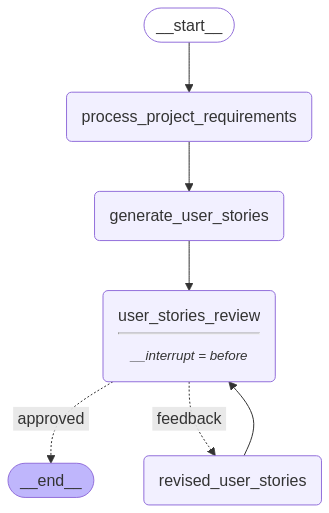

In [46]:
display(Image(user_story_workflow.get_graph().draw_mermaid_png()))

In [47]:
# Input
# project_requirements = ProjectRequirements(
#     title = "A snake and ladder game in web-app",
#     description = "A snake and ladder game in web-app with multiple players and a board",
#     requirements = ["A snake and ladder game in web-app", "Multi players should be supported", "Board should be displayed", "Players should be able to move their tokens based on the dice roll", "Snakes and ladders should be displayed on the board", "Players should be able to see the final positions of all players"]
# )
project_requirements = ProjectRequirements(
    title = project_title,
    description = project_description,
    requirements = requirements
)

initial_story_state = {
    "project_requirements" : project_requirements,
    "user_stories": [],
    "user_stories_messages": HumanMessage(content=f"{project_requirements}"),
    "status": "in_progress",
    "owner_feedback": "",
    " b " : 0
}

# Thread
thread = {"configurable": {"thread_id": "12343"}}

for event in user_story_workflow.stream(initial_story_state, thread, stream_mode="values"):
    print(event)


{'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}, 'status': 'in_progress', 'user_stories': [], 'user_stories_messages': [HumanMessage(content="{'title': 'PayMate: Your Ultimate Payment Companion', 'de

In [48]:
{'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}, 'status': 'pending_approval', 'revised_count': 0, 'user_stories': [{'story_id': 'US-001', 'title': 'Secure Login with Multi-Factor Authentication', 'description': 'As a user, I want to securely access my account using multiple authentication methods, so that my financial data remains protected.', 'acceptance_criteria': ['User can log in using fingerprint recognition.', 'User can log in using facial recognition.', 'User can log in using MPIN.', 'System shows an error message for failed authentication attempts.']}, {'story_id': 'US-002', 'title': 'Link and Manage Multiple Bank Accounts', 'description': 'As a user, I want to link multiple bank accounts to my PayMate profile, so that I can perform seamless fund transfers.', 'acceptance_criteria': ['User can add multiple bank accounts to their profile.', 'User can select a default bank account for transactions.', 'User can transfer funds between linked bank accounts.', 'Balance of linked accounts is updated in real-time.']}, {'story_id': 'US-003', 'title': 'Access Instant Micro-Loans', 'description': 'As a user, I want to apply for instant micro-loans with minimal documentation, so that I can address urgent financial needs.', 'acceptance_criteria': ['User can apply for a micro-loan through the app.', 'System processes the loan application in real-time.', "Approved loan amount is disbursed instantly to the user's bank account.", 'User can view loan details including amount, tenure, and repayment terms.']}, {'story_id': 'US-004', 'title': 'Pay Utility Bills Directly', 'description': 'As a user, I want to pay my utility bills directly through the app, so that I can manage all my payments in one place.', 'acceptance_criteria': ['User can add utility billers (e.g., electricity, water, gas, broadband).', 'User can pay bills using their linked bank account or UPI.', 'User can view a history of past bill payments.', 'System confirms the successful payment with a notification.']}], 'user_stories_messages': [HumanMessage(content="{'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}", additional_kwargs={}, response_metadata={}, id='c09c2573-7c14-4fc2-8111-368f1fd4b45f'), AIMessage(content="I've received your project requirements. I'll now generate user stories based on these requirements.", additional_kwargs={}, response_metadata={}, id='f977fc5f-edad-498d-bcdc-7795465e763b'), AIMessage(content="Based on your requirements, I've generated 4 user stories. Please review these user stories and provide feedback or type 'Approved' if you're satisfied.", additional_kwargs={}, response_metadata={}, id='db5c11e1-ae41-41a6-a00e-667dc6316857')]}

{'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion',
  'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.',
  'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b',
   'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.',
   'Provide users with access to instant micro-loans with minimal documentation.',
   'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']},
 'status': 'pending_approval',
 'revised_count': 0,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Login with Multi-Factor 

In [49]:
user_state = user_story_workflow.get_state(thread) 
user_state.next

('user_stories_review',)

In [34]:
user_feedback

'Add user story to buy insurance from the app.'

In [52]:
user_story_workflow.update_state(thread, { "user_stories_messages" : HumanMessage(content=f'{user_feedback}')})

# Continue the graph execution
for event in user_story_workflow.stream(None, thread, stream_mode="values"):
    print(event)

In should_revise_user_stories
state :  {'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}, 'status': 'feedback', 'revised_count': 0, 'user_stories': [{'story_id': 'US-001', 'title': 'Secure Login with M

In [53]:
{'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}, 'status': 'pending_approval', 'revised_count': 1, 'user_stories': [{'story_id': 'US-001', 'title': 'Secure Login with Multi-Factor Authentication', 'description': 'As a user, I want to securely access my account using multiple authentication methods, so that my financial data remains protected.', 'acceptance_criteria': ['User can log in using fingerprint recognition.', 'User can log in using facial recognition.', 'User can log in using MPIN.', 'System shows an error message for failed authentication attempts.']}, {'story_id': 'US-002', 'title': 'Link and Manage Multiple Bank Accounts', 'description': 'As a user, I want to link multiple bank accounts to my PayMate profile, so that I can perform seamless fund transfers.', 'acceptance_criteria': ['User can add multiple bank accounts to their profile.', 'User can select a default bank account for transactions.', 'User can transfer funds between linked bank accounts.', 'Balance of linked accounts is updated in real-time.']}, {'story_id': 'US-003', 'title': 'Access Instant Micro-Loans', 'description': 'As a user, I want to apply for instant micro-loans with minimal documentation, so that I can address urgent financial needs.', 'acceptance_criteria': ['User can apply for a micro-loan through the app.', 'System processes the loan application in real-time.', "Approved loan amount is disbursed instantly to the user's bank account.", 'User can view loan details including amount, tenure, and repayment terms.']}, {'story_id': 'US-004', 'title': 'Pay Utility Bills Directly', 'description': 'As a user, I want to pay my utility bills directly through the app, so that I can manage all my payments in one place.', 'acceptance_criteria': ['User can add utility billers (e.g., electricity, water, gas, broadband).', 'User can pay bills using their linked bank account or UPI.', 'User can view a history of past bill payments.', 'System confirms the successful payment with a notification.']}, {'story_id': 'US-005', 'title': 'Purchase Insurance Policies Directly', 'description': 'As a user, I want to purchase various insurance policies through the app, so that I can protect my financial well-being.', 'acceptance_criteria': ['User can browse and select from various insurance policy options (e.g., health, life, auto, home).', 'User can view detailed policy information including coverage, premiums, and terms.', 'User can purchase the selected policy and receive a confirmation with policy details.', "System provides a summary of purchased policies in the user's profile."]}], 'user_stories_messages': [HumanMessage(content="{'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}", additional_kwargs={}, response_metadata={}, id='c09c2573-7c14-4fc2-8111-368f1fd4b45f'), AIMessage(content="I've received your project requirements. I'll now generate user stories based on these requirements.", additional_kwargs={}, response_metadata={}, id='f977fc5f-edad-498d-bcdc-7795465e763b'), AIMessage(content="Based on your requirements, I've generated 4 user stories. Please review these user stories and provide feedback or type 'Approved' if you're satisfied.", additional_kwargs={}, response_metadata={}, id='db5c11e1-ae41-41a6-a00e-667dc6316857'), HumanMessage(content='Add user story to buy insurance from the app.', additional_kwargs={}, response_metadata={}, id='ad9b63db-06fc-4493-bdd9-87f0a7c2d1ea'), AIMessage(content="I've received your feedback. I'll revise the user stories accordingly.", additional_kwargs={}, response_metadata={}, id='44387b42-df69-4263-b99b-b620f953147f'), HumanMessage(content='Add user story to buy insurance from the app.', additional_kwargs={}, response_metadata={}, id='e2d84fcc-0d21-47d2-906d-37a691643694'), HumanMessage(content='Add user story to buy insurance from the app.', additional_kwargs={}, response_metadata={}, id='547e217e-f15e-4e52-9cdc-0c2be38a740f'), AIMessage(content="I've revised the user stories based on your feedback.\n\nPlease review these updated user stories and provide additional feedback or type 'Approved' if you're satisfied.", additional_kwargs={}, response_metadata={}, id='2cf2ffa1-ae7e-40ef-86d8-f88101eb173a')]}


{'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion',
  'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.',
  'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b',
   'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.',
   'Provide users with access to instant micro-loans with minimal documentation.',
   'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']},
 'status': 'pending_approval',
 'revised_count': 1,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Login with Multi-Factor 

In [54]:
user_story_workflow.update_state(thread, { "user_stories_messages" : HumanMessage(content='Approved')})

# Continue the graph execution
for event in user_story_workflow.stream(None, thread, stream_mode="values"):
    print(event)

{'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}, 'status': 'pending_approval', 'revised_count': 1, 'user_stories': [{'story_id': 'US-001', 'title': 'Secure Login with Multi-Factor Authentication', 'd

In [56]:
 {'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}, 'status': 'completed', 'revised_count': 1, 'user_stories': [{'story_id': 'US-001', 'title': 'Secure Login with Multi-Factor Authentication', 'description': 'As a user, I want to securely access my account using multiple authentication methods, so that my financial data remains protected.', 'acceptance_criteria': ['User can log in using fingerprint recognition.', 'User can log in using facial recognition.', 'User can log in using MPIN.', 'System shows an error message for failed authentication attempts.']}, {'story_id': 'US-002', 'title': 'Link and Manage Multiple Bank Accounts', 'description': 'As a user, I want to link multiple bank accounts to my PayMate profile, so that I can perform seamless fund transfers.', 'acceptance_criteria': ['User can add multiple bank accounts to their profile.', 'User can select a default bank account for transactions.', 'User can transfer funds between linked bank accounts.', 'Balance of linked accounts is updated in real-time.']}, {'story_id': 'US-003', 'title': 'Access Instant Micro-Loans', 'description': 'As a user, I want to apply for instant micro-loans with minimal documentation, so that I can address urgent financial needs.', 'acceptance_criteria': ['User can apply for a micro-loan through the app.', 'System processes the loan application in real-time.', "Approved loan amount is disbursed instantly to the user's bank account.", 'User can view loan details including amount, tenure, and repayment terms.']}, {'story_id': 'US-004', 'title': 'Pay Utility Bills Directly', 'description': 'As a user, I want to pay my utility bills directly through the app, so that I can manage all my payments in one place.', 'acceptance_criteria': ['User can add utility billers (e.g., electricity, water, gas, broadband).', 'User can pay bills using their linked bank account or UPI.', 'User can view a history of past bill payments.', 'System confirms the successful payment with a notification.']}, {'story_id': 'US-005', 'title': 'Purchase Insurance Policies Directly', 'description': 'As a user, I want to purchase various insurance policies through the app, so that I can protect my financial well-being.', 'acceptance_criteria': ['User can browse and select from various insurance policy options (e.g., health, life, auto, home).', 'User can view detailed policy information including coverage, premiums, and terms.', 'User can purchase the selected policy and receive a confirmation with policy details.', "System provides a summary of purchased policies in the user's profile."]}], 'user_stories_messages': [HumanMessage(content="{'title': 'PayMate: Your Ultimate Payment Companion', 'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', 'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']}", additional_kwargs={}, response_metadata={}, id='c09c2573-7c14-4fc2-8111-368f1fd4b45f'), AIMessage(content="I've received your project requirements. I'll now generate user stories based on these requirements.", additional_kwargs={}, response_metadata={}, id='f977fc5f-edad-498d-bcdc-7795465e763b'), AIMessage(content="Based on your requirements, I've generated 4 user stories. Please review these user stories and provide feedback or type 'Approved' if you're satisfied.", additional_kwargs={}, response_metadata={}, id='db5c11e1-ae41-41a6-a00e-667dc6316857'), HumanMessage(content='Add user story to buy insurance from the app.', additional_kwargs={}, response_metadata={}, id='ad9b63db-06fc-4493-bdd9-87f0a7c2d1ea'), AIMessage(content="I've received your feedback. I'll revise the user stories accordingly.", additional_kwargs={}, response_metadata={}, id='44387b42-df69-4263-b99b-b620f953147f'), HumanMessage(content='Add user story to buy insurance from the app.', additional_kwargs={}, response_metadata={}, id='e2d84fcc-0d21-47d2-906d-37a691643694'), HumanMessage(content='Add user story to buy insurance from the app.', additional_kwargs={}, response_metadata={}, id='547e217e-f15e-4e52-9cdc-0c2be38a740f'), AIMessage(content="I've revised the user stories based on your feedback.\n\nPlease review these updated user stories and provide additional feedback or type 'Approved' if you're satisfied.", additional_kwargs={}, response_metadata={}, id='2cf2ffa1-ae7e-40ef-86d8-f88101eb173a'), HumanMessage(content='Approved', additional_kwargs={}, response_metadata={}, id='a972fa09-be51-4206-b7a2-4840df671fcb'), AIMessage(content='Great! Your user stories have been finalized. You can now proceed with your design process.', additional_kwargs={}, response_metadata={}, id='abe32885-d480-458c-bda1-4b5212ff8f83')]}


{'project_requirements': {'title': 'PayMate: Your Ultimate Payment Companion',
  'description': 'PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.',
  'requirements': ['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b',
   'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.',
   'Provide users with access to instant micro-loans with minimal documentation.',
   'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']},
 'status': 'completed',
 'revised_count': 1,
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Login with Multi-Factor Authent